<a href="https://colab.research.google.com/github/saipuneet357/Generative-Adversarial-Networks/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import numpy as np 
import pandas as pd
import os 
os.environM="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 1
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Lambda, Dense, Flatten, Reshape, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras import backend as K

In [72]:
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [73]:
location = '/content/gdrive/MyDrive/NotMnist'  

In [74]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [75]:
train_data = extract_data(location+'/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data(location+'/t10k-images-idx3-ubyte.gz', 10000)

In [76]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [77]:
train_labels = extract_labels(location+'/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels(location+'/t10k-labels-idx1-ubyte.gz',10000)

In [78]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [79]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: D)')

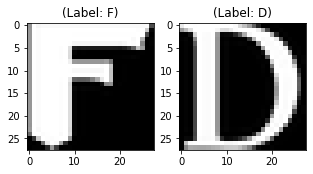

In [80]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [81]:
train_data = train_data.reshape(-1,28,28,1)
test_data = test_data.reshape(-1, 28, 28, 1)
train_data = train_data/np.max(train_data)
test_data = test_data/np.max(test_data)
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [82]:
batch_size = 128
epochs = 40
inChannel = 1
x, y = 28, 28
latent_dim = 100
input_img = Input(shape = (latent_dim, ))
max_filters = 64

In [110]:
dense = Dense(256, name='dense_1')(input_img)
dense2 = Dense(512, name='dense_2', activation='relu')(dense)
dense3 = Dense(1012, name='dense_3', activation='relu')(dense2)
dense4 = Dense(784, name='dense_4', activation='tanh')(dense3)

In [111]:
from keras.optimizers import Adam
generator = Model(input_img, dense4, name='generator')
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [112]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1012)              519156    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               794192    
Total params: 1,470,788
Trainable params: 1,470,788
Non-trainable params: 0
_________________________________________________________________


In [124]:
discriminator_input = Input(shape=(784))
flatten = Flatten()(discriminator_input)
dense5 = Dense(1024, activation='relu')(flatten)
d = Dropout(0.3)(dense5)
dense6 = Dense(512, activation='relu')(d)
d1 = Dropout(0.3)(dense6)
dense7 = Dense(256, activation='relu')(d1)
d2 = Dropout(0.3)(dense7)
output = Dense(1, activation='sigmoid')(d2)
discriminator = Model(discriminator_input, output, name='discriminator')
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [125]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)             

In [126]:
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=opt)

In [127]:
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
generator (Functional)       (None, 784)               1470788   
_________________________________________________________________
discriminator (Functional)   (None, 1)                 1460225   
Total params: 2,931,013
Trainable params: 1,470,788
Non-trainable params: 1,460,225
_________________________________________________________________


In [141]:
batch_count = train_X.shape[0] / batch_size

for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in range(int(batch_count)):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
        image_batch = train_X[np.random.randint(0, train_X.shape[0], size=batch_size)]
        image_batch = np.reshape(image_batch, (image_batch.shape[0],image_batch.shape[1]*image_batch.shape[2]))
        
        # Generate fake MNIST images
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images])

        # Labels for generated and real data
        y_dis = np.zeros(2*batch_size)
        # One-sided label smoothing
        y_dis[:batch_size] = 0.9

        # Train discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gen)


--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
--------------- Epoch 24 ---------------
--------------- Epoch 25 

1


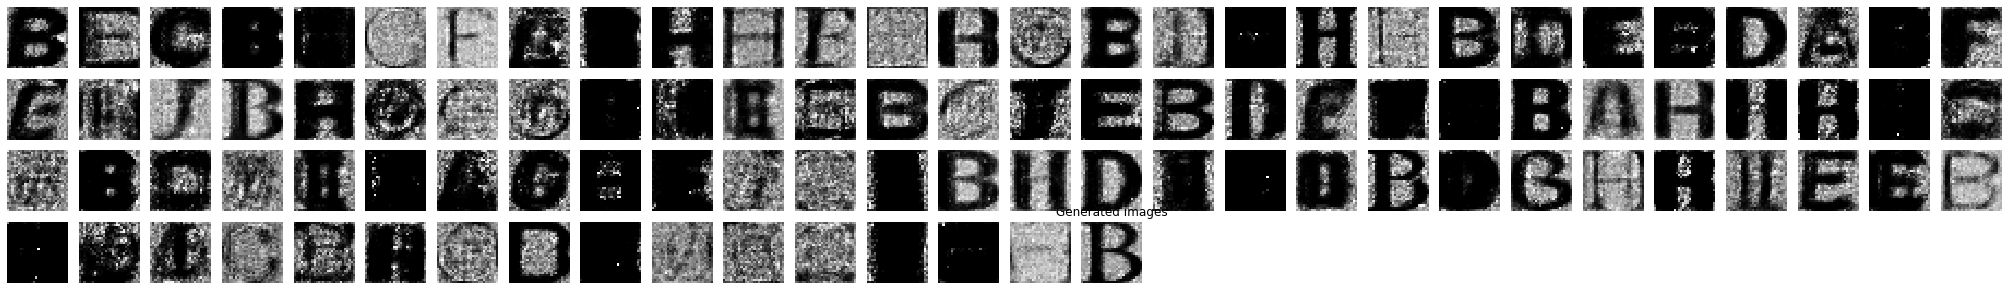

In [142]:
noise = np.random.normal(0, 1, size=[100, latent_dim])
generated_images = generator.predict(noise)
generated_images = generated_images.reshape(100, 28, 28)
print(1)
plt.figure(figsize=(28, 28))
for i in range(generated_images.shape[0]):
    plt.subplot(28, 28, i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.title('Generated images')
plt.show()
# plt.savefig('gan_generated_image_epoch_%d.png' % epoch)